# 基于机器学习的径流预报

数据集: `./dataset/01333000.csv`

## 任务一、数据分析

1. 通过给定数据的网址或文档，理解所用数据集（01333000.csv）英文字段的中文含义。
2. 对数据进行数据可视化分析，深入了解数据分布及相关性等情况。

### [Answer1-1] 各字段含义

```csv
Date,Discharge,Dayl,Prcp,Srad,Swe,Tmax,Tmin,Vp
2000-01-01,39.0,32140.8,0.0,204.85,0.0,1.56,-9.17,302.56
2000-01-02,39.0,32140.8,0.0,214.92,0.0,6.99,-4.99,436.29
2000-01-03,44.0,32140.8,2.58,176.35,0.0,11.65,0.86,641.53
```

![parameter-desc](../docs/images/parameter-desc.png)

- Date

    日期

    年-月-日

- Discharge
    
    流量

- Dayl(s)

    日间时

    以秒计算的白天时间

    单位：秒

- Prcp 

    每日总降水量，降水总量转换为水当量深度的总和。

    单位：毫米(mm)

- Srad

    短波辐射

    入射短波辐射通量密度以瓦特每平方米为单位，在白天的日照周期内平均采用。
    
    注：日总辐射量（MJ/m2/天）可计算为如下：（（srad（W/m2）*dayl（s/day））/l，000,000）

- Swe

    雪水当量

    积雪内含水量。

    单位：kg/m^2

- Tmax

    最高空气温度

    日最高气温2m，单位为摄氏度。

    单位：摄氏度 ℃

- Tmin

    最低空气温度

    日最低气温2m，单位为摄氏度。

    单位：摄氏度 ℃

- Vp(Pa)

    大气压

    日平均大气压

    单位：Pa

### 导包、日期预处理

In [4]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import math
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR

from sklearn.metrics import r2_score 

%matplotlib inline

data = pd.read_csv("../dataset/01333000.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index("Date", inplace=True)

print("Success")

not_index_column_list=["Discharge","Dayl","Prcp","Srad","Swe","Tmax","Tmin","Vp"]

Success


### [Answer1-2-1] 时间序列数据可视化

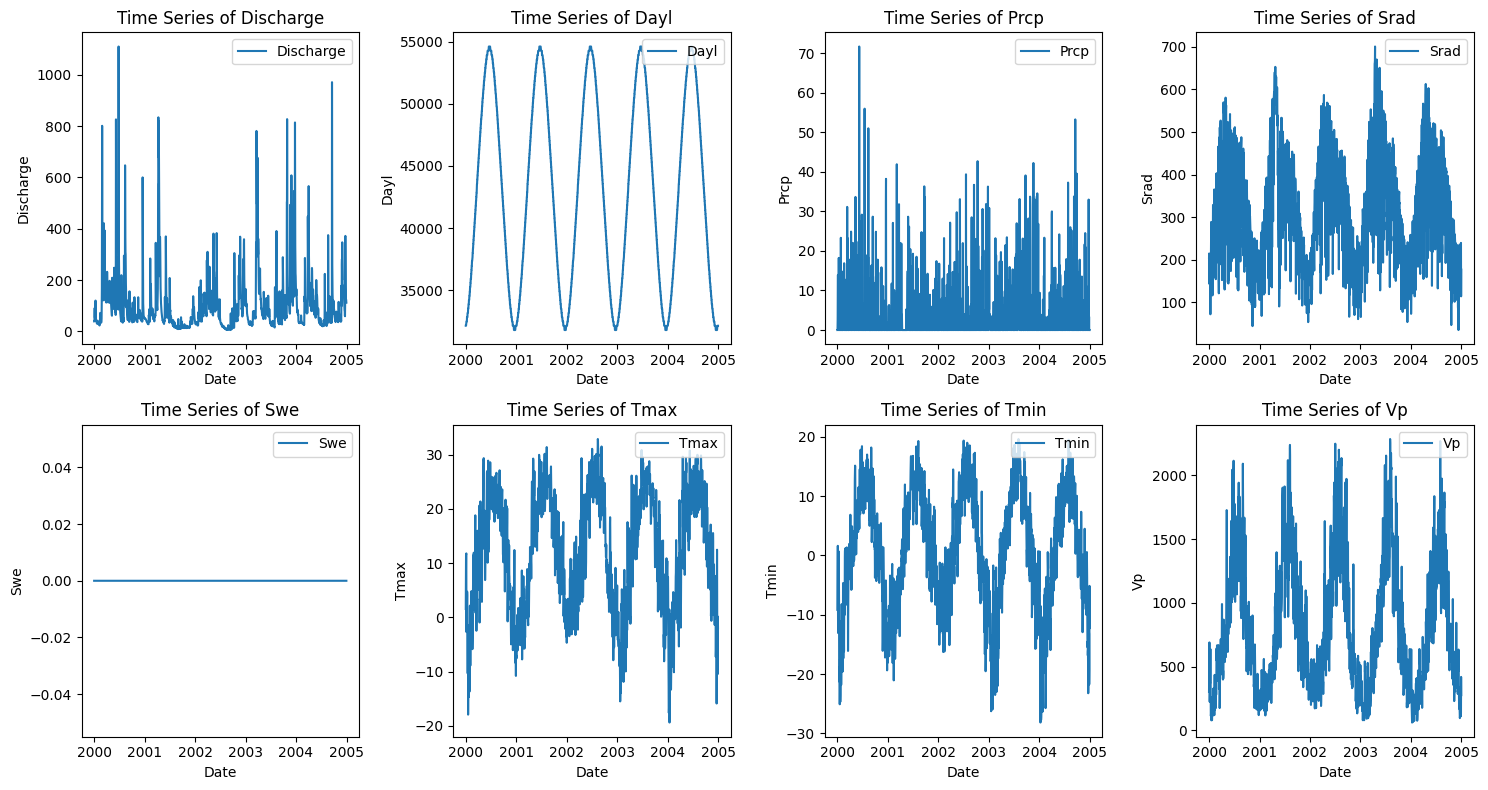

In [27]:
for i, param in enumerate(not_index_column_list):
    plt.subplot(2, 4, i+1)
    plt.plot(data.index, data[param], label=param)
    plt.xlabel("Date")
    plt.ylabel(param)
    plt.title(f"Time Series of {param}")
    plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

### [Answer1-2-2] 直方图

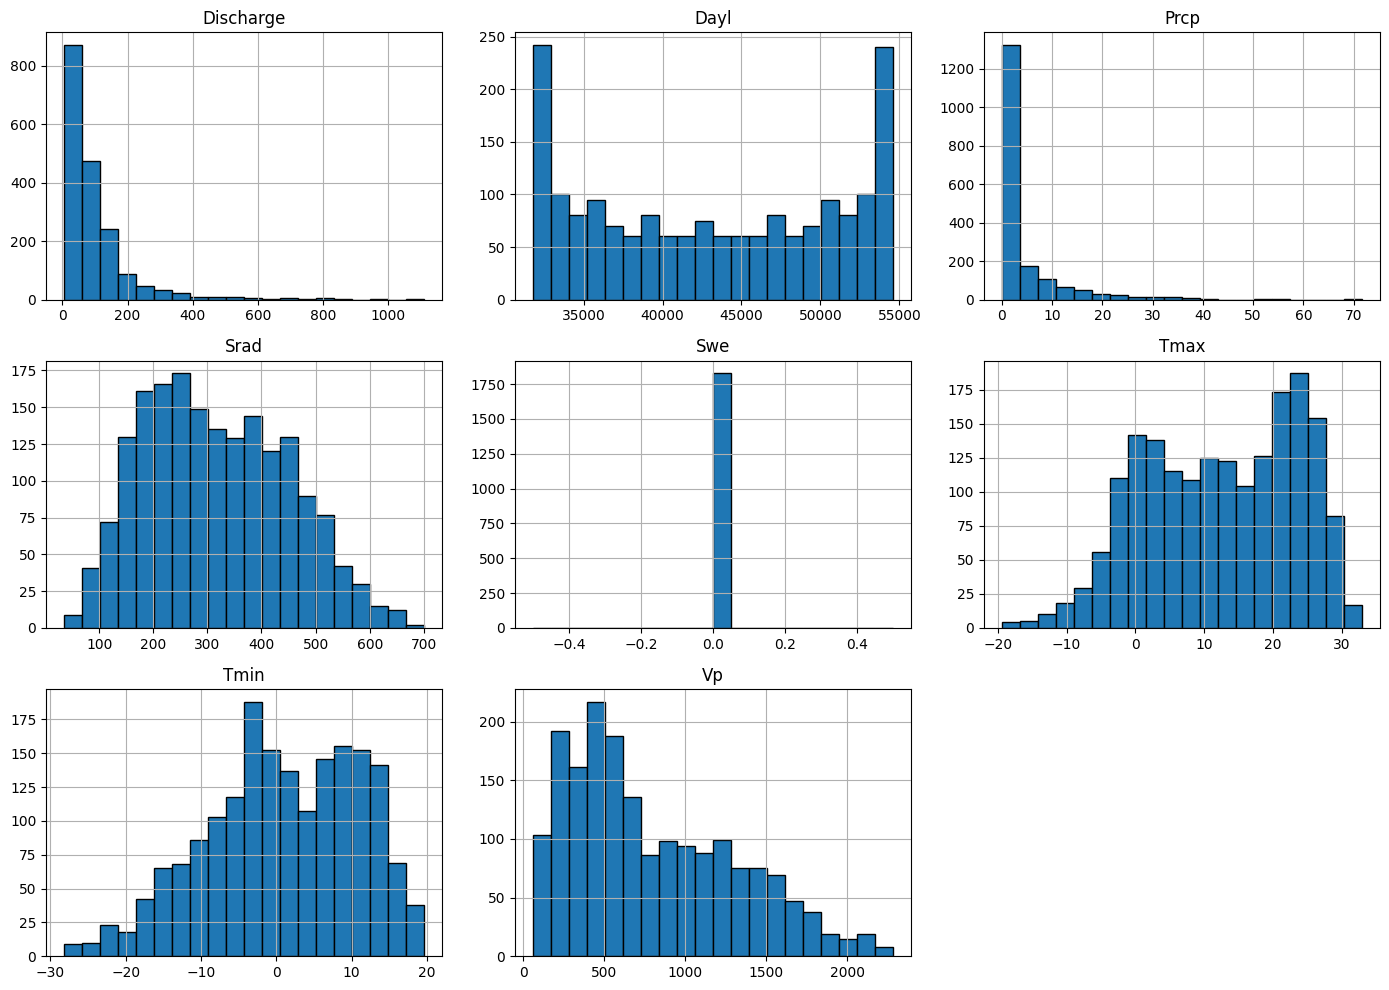

In [31]:
data.hist(figsize=(14, 10), bins=20, edgecolor="black")
plt.tight_layout()
plt.show()

### [Answer1-2-3] 箱型图

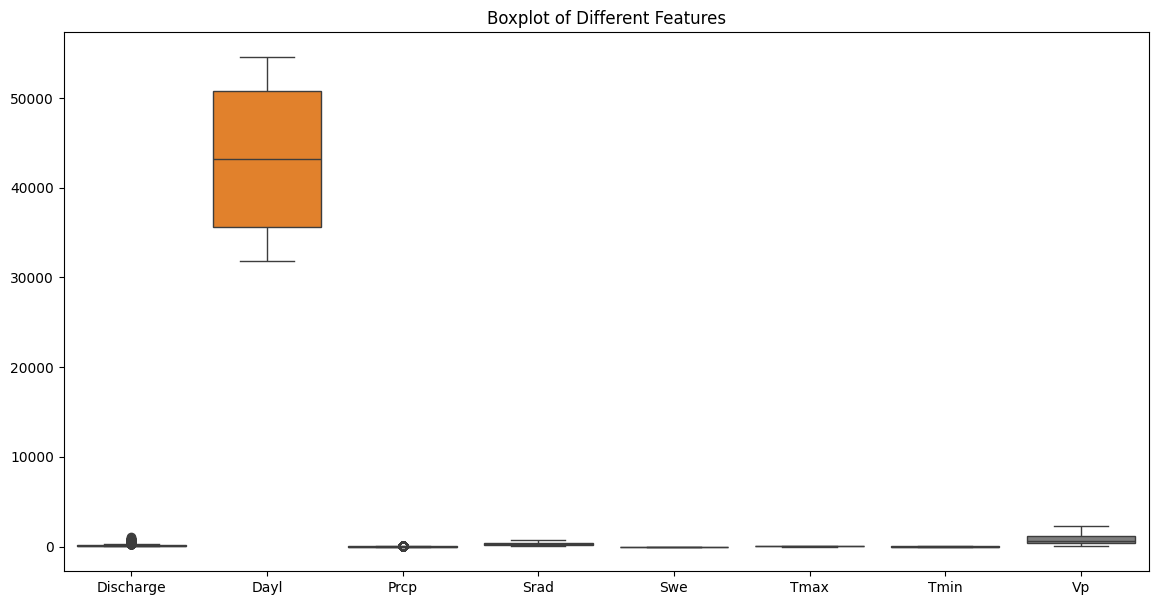

In [32]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=data)
plt.title("Boxplot of Different Features")
plt.show()

### [Answer1-2-4] 皮尔逊相关系数热力图

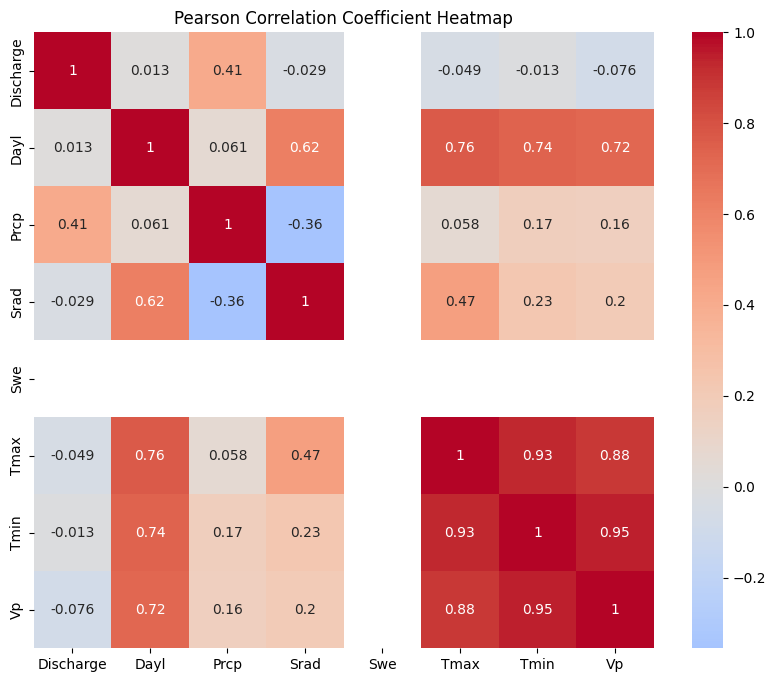

In [33]:
# 计算皮尔逊相关系数
corr = data.corr()

# 绘制皮尔逊相关系数热力图
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Pearson Correlation Coefficient Heatmap")
plt.show()

## 任务二、特征工程
1. 特征归一化：总结常用的特征归一化方法，并实现最小-最大归一化、Z-score标准化方法。
2. 特征选择：总结常用的特征选择方法，并实现皮尔逊相关系数法和互信息法。

### [Answer2-1-1] 常用的特征归一化方法
- 最小-最大归一化：可以将所有特征值压缩（或拓展）到[0,1]区间

![最小-最大归一化](../docs/images/max-min.png)

- Z-score标准化：将所有特征值缩放到均值为0、标注差为1的分布上。

![Z-score标准化](../docs/images/z-score.png)

### [Answer2-2-1] 常用的特征选择方法
- 过滤法(Filter)：按照发散性或相关性对各个特征进行评分，设定阈值或者待选择特征的个数进行筛选
- 包装法(Wrapper)：根据评价函数，每次选择若干特征，或者排除若干特征
- 嵌入法(Embedded)：先使用某些机器学习的模型进行训练，得到各个特征的权值系数，根据系数从大到小选择特征（类似于Filter，只不过系数是通过训练得来的）
- 特征合成：比较经典的降维方法有主成分分析法（PCA），它可以将多个原始维度数据合成新维度数据。

### [Answer2-1-2] Max-Min标准化

In [48]:
(data-data.min(axis=0))/(data.max(axis=0)-data.min(axis=0))

,Discharge,Dayl,Prcp,Srad,Swe,Tmax,Tmin,Vp
Date,,,,,,,,
2000-01-01,0.030594,0.015152,0.000000,0.254895,NaN,0.400612,0.397490,0.108423
2000-01-02,0.030594,0.015152,0.000000,0.270025,NaN,0.504496,0.484937,0.168596
2000-01-03,0.035119,0.015152,0.036008,0.212072,NaN,0.593648,0.607322,0.260946
2000-01-04,0.064989,0.020953,0.119749,0.162457,NaN,0.592883,0.623222,0.282567
2000-01-05,0.077661,0.030303,0.194417,0.231064,NaN,0.596518,0.462134,0.147938
...,...,...,...,...,...,...,...,...
2004-12-27,0.119298,0.015152,0.047034,0.143585,NaN,0.285250,0.312762,0.071571
2004-12-28,0.103910,0.015152,0.000000,0.262407,NaN,0.170652,0.134519,0.021864
2004-12-29,0.107531,0.015152,0.000000,0.307334,NaN,0.291180,0.184519,0.032582


### [Answer2-1-3] Z-score 标准化

In [49]:
(data-data.mean(axis=0))/data.std(axis=0)

,Discharge,Dayl,Prcp,Srad,Swe,Tmax,Tmin,Vp
Date,,,,,,,,
2000-01-01,-0.534134,-1.412140,-0.507926,-0.853108,NaN,-0.989416,-0.988175,-0.976074
2000-01-02,-0.534134,-1.412140,-0.507926,-0.776752,NaN,-0.494216,-0.574446,-0.713606
2000-01-03,-0.489018,-1.412140,-0.160847,-1.069210,NaN,-0.069237,0.004575,-0.310788
2000-01-04,-0.191251,-1.395223,0.646314,-1.319584,NaN,-0.072885,0.079798,-0.216482
2000-01-05,-0.064926,-1.367963,1.366033,-0.973367,NaN,-0.055558,-0.682332,-0.803712
...,...,...,...,...,...,...,...,...
2004-12-27,0.350143,-1.412140,-0.054571,-1.414820,NaN,-1.539334,-1.389036,-1.136817
2004-12-28,0.196748,-1.412140,-0.507926,-0.815196,NaN,-2.085605,-2.232328,-1.353633
2004-12-29,0.232841,-1.412140,-0.507926,-0.588479,NaN,-1.511063,-1.995771,-1.306882


### [Answer2-2-2] 皮尔逊相关系数法

In [50]:
data.corr()

,Discharge,Dayl,Prcp,Srad,Swe,Tmax,Tmin,Vp
Discharge,1.000000,0.012898,0.408723,-0.029112,NaN,-0.048650,-0.012899,-0.076183
Dayl,0.012898,1.000000,0.060680,0.616363,NaN,0.764397,0.737748,0.724601
Prcp,0.408723,0.060680,1.000000,-0.355773,NaN,0.057969,0.166276,0.158310
Srad,-0.029112,0.616363,-0.355773,1.000000,NaN,0.474864,0.227878,0.201914
Swe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tmax,-0.048650,0.764397,0.057969,0.474864,NaN,1.000000,0.930042,0.883733
Tmin,-0.012899,0.737748,0.166276,0.227878,NaN,0.930042,1.000000,0.947817
Vp,-0.076183,0.724601,0.158310,0.201914,NaN,0.883733,0.947817,1.000000


由上图可以看到径流量和日间时、每日总降水量成正相关，与短波辐射、最高/低空气温度以及大气压成负相关

且与每日总降水量成中等相关程度，相关性在其余参数中最强

### [Answer2-2-3] 互信息法

In [63]:
# 将'Discharge'作为目标变量
target = data["Discharge"]
features = data.drop(columns=["Discharge"])
mutual_info = mutual_info_regression(features, target)
pd.Series(mutual_info, index=features.columns)

Dayl    0.241856
Prcp    0.071680
Srad    0.098011
Swe     0.000000
Tmax    0.144539
Tmin    0.159338
Vp      0.147492
dtype: float64

由上面的结果可得，虽然降水的线性影响最大，但是其对于径流量预测所提供的信息量并不是最多的

## 任务三、机器学习回归
1. 实现3种机器学习算法（岭回归、KNN回归、支持向量回归）。
3. 利用Grid Search CV（网格搜索）调超参数。
4. 基于编号01333000流域的数据（01333000.csv），进行径流预报。
5. 针对编号01333000流域，确定预报精度最高的特征工程方法+机器学习算法组合。

### [Answer3-0] 适用于径流预报的机器学习算法
1. **线性回归模型**：用于建立径流与影响因素（如降雨量、土壤含水量等）之间的线性关系模型。

2. **决策树模型**：通过树形结构对输入特征进行分段，从而预测径流量。

3. **随机森林**：由多棵决策树组成的集成学习模型，通常比单棵决策树有更好的性能表现。

4. **支持向量机（SVM）**：用于分类和回归分析的监督学习模型，可以适用于径流量的预测。

5. **神经网络**：深度学习领域的神经网络模型，可以处理复杂的非线性关系，适合处理大量数据和复杂的径流预报问题。

6. **K近邻算法**：基于样本的相似性进行预测的非参数化算法，适用于径流预测中的空间和时间关系。

7. **梯度提升机（Gradient Boosting Machine，GBM）**：一种集成学习技术，通过逐步优化多个弱预测器来构建强预测模型，常用于径流预测中的精细调整。

8. **长短期记忆人工神经网络**（Long-Short Term Memory,LSTM）是一种特殊的递归神经网络 (RNN)，它具有记忆和遗忘的能力，可以处理和预测复杂的时间序列数据123。LSTM的设计结构适合于处理和预测时间序列中间隔和延迟非常长的重要事件


### 数据预处理

|变量|含义|
|---|---|
|X_train|	划分的训练集数据|
|X_test	|划分的测试集数据   |
|y_train|	划分的训练集标签|
|y_test	|划分的测试集标签   |

In [521]:
def make_splited_data(df):
    year_data_list = []

    X_train_list = []
    X_test_list  = []
    y_train_list = []
    y_test_list  = []

    for i in range(5):
        year_data_list.append(df.query(f'Date >= "200{i}-01-01" and Date < "200{i+1}-01-01"'))
        features = year_data_list[i].drop(columns=["Discharge"])
        xtrain, xtest, ytrain, ytest = train_test_split(features, year_data_list[i]["Discharge"], test_size=0.2)
        X_train_list.append(xtrain)
        X_test_list.append(xtest)
        y_train_list.append(ytrain)
        y_test_list.append(ytest)

    def make_together(data_list: pd.DataFrame) -> pd.DataFrame:
        res = data_list[0]
        for i in range(1, len(data_list)):
            res = pd.concat([res, data_list[i]], ignore_index=True)
        return res

    X_train = make_together(X_train_list)
    X_test  = make_together(X_test_list)
    y_train = make_together(y_train_list)
    y_test  = make_together(y_test_list)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = make_splited_data(data)

models = {
    "Ridge": Ridge(),
    "KNN": KNeighborsRegressor(),
    # "SVR": SVR(),
}
param_grids = {
    "Ridge": {"alpha": np.arange(1, 500, 1)},
    "KNN": {"n_neighbors": np.arange(1, 100, 1)},
    # "SVR": {"C": [0.1, 1, 10], "kernel": ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']},
}

best_models = {}
for model_name in models:
    grid_search = GridSearchCV(
        models[model_name],
        param_grids[model_name],
        cv=3,
        scoring="neg_mean_squared_error",
    )
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"best alpha: {grid_search.best_params_}")

for model_name in best_models:
    model = best_models[model_name]
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"[{model_name}] R2: {r2}")

best alpha: {'alpha': 452}
best alpha: {'n_neighbors': 12}
[Ridge] R2: 0.33970112375467765
[KNN] R2: 0.03633254789972973


### [Answer3-1] 机器学习算法实现

#### [Answer3-1-1] 岭回归实现

In [380]:
def Ridge_r2() -> float:
    estimator = Ridge().fit(X=X_train, y=y_train)
    y_pred = estimator.predict(X_test)
    return r2_score(y_test, y_pred)

print(f"[Ridge] R2: {Ridge_r2()}")

[Ridge] R2: 0.3412706759807582


#### [Answer3-1-2] KNN回归实现

In [381]:
def KNeighborsRegressor_r2() -> float:
    estimator2 = KNeighborsRegressor().fit(X=X_train, y=y_train)
    y_pred2 = estimator2.predict(X_test)
    return r2_score(y_test, y_pred2)

print(f"[KNN] R2: {KNeighborsRegressor_r2()}")

[KNN] R2: 0.21662961814407222


#### [Answer3-1-3] 支持向量回归实现

In [382]:
def SVR_r2() -> float:
    estimator3 = SVR().fit(X=X_train, y=y_train)
    y_pred3 = estimator3.predict(X_test)
    return r2_score(y_test, y_pred3)

print(f"[SVR] R2: {SVR_r2()}")

[SVR] R2: -0.097092403697701


### [Answer3-2] 利用Grid Search CV（网格搜索）调超参数

In [503]:
models = {
    "Ridge": Ridge(),
    "KNN": KNeighborsRegressor(),
    # "SVR": SVR(),
}
param_grids = {
    "Ridge": {"alpha": np.arange(800, 1000, 1)},
    "KNN": {"n_neighbors": np.arange(1, 100, 1)},
    # "SVR": {"C": [0.1, 1, 10], "kernel": ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']},
}

best_models = {}
for model_name in models:
    grid_search = GridSearchCV(
        models[model_name],
        param_grids[model_name],
        cv=3,
        scoring="neg_mean_squared_error",
    )
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"best alpha: {grid_search.best_params_}")

for model_name in best_models:
    model = best_models[model_name]
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"[{model_name}] R2: {r2}")

best alpha: {'alpha': 864}
best alpha: {'n_neighbors': 28}
[Ridge] R2: 0.32009544268456036
[KNN] R2: 0.1435251749927824


### [Answer3-3] 确定预报精度最高的特征工程方法+机器学习算法组合

In [542]:
# Min-Max归一化
min_max_scaler = MinMaxScaler()
data_min_max_normalized = pd.DataFrame(
    min_max_scaler.fit_transform(data), columns=data.columns, index=data.index
)

# Z-score标准化
z_score_scaler = StandardScaler()
data_z_score_normalized = pd.DataFrame(
    z_score_scaler.fit_transform(data), columns=data.columns, index=data.index
)

# 特征工程方法列表
feature_eng_methods = {
    "Min-Max": data_min_max_normalized,
    "Z-score": data_z_score_normalized,
}

models = {
    "Ridge": Ridge(),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
}
param_grids = {
    "Ridge": {"alpha": np.arange(1, 500, 1)},
    "KNN": {"n_neighbors": np.arange(1, 100, 1)},
    "SVR": {"C": np.arange(1, 8, 0.1), "kernel": ['poly', 'rbf']},
}

results = {}
pretreated_data = {}
best_models = {}
for method_name, processed_data in feature_eng_methods.items():
    X_train, X_test, y_train, y_test = make_splited_data(processed_data)
    pretreated_data[method_name] = (X_train, X_test, y_train, y_test)
    for model_name in models:
        grid_search = GridSearchCV(
            models[model_name],
            param_grids[model_name],
            cv=3,
            scoring="neg_mean_squared_error",
        )
        grid_search.fit(X_train, y_train)
        best_estimator = grid_search.best_estimator_
        print(f"[{method_name} + {model_name}] best param: {grid_search.best_params_}")

        y_pred = best_estimator.predict(X_test)
        best_models[model_name] = best_estimator
        r2 = r2_score(y_test, y_pred)
        results[(method_name, model_name)] = r2

# 输出结果
for (method, model), r2 in results.items():
    print(f"{method} + {model:<6} R2: {r2}")

# 找到最优组合
best_combination = max(results, key=results.get)
best_method, best_model = best_combination[0], best_combination[1]
print(f"最佳组合是: 特征工程方法 {best_method} + {best_model}, R2: {results[best_combination]}")



[Min-Max + Ridge] best param: {'alpha': 1}
[Min-Max + KNN] best param: {'n_neighbors': 11}
[Min-Max + SVR] best param: {'C': 4.800000000000003, 'kernel': 'rbf'}
[Z-score + Ridge] best param: {'alpha': 9}
[Z-score + KNN] best param: {'n_neighbors': 9}
[Z-score + SVR] best param: {'C': 7.900000000000006, 'kernel': 'rbf'}
Min-Max + Ridge  R2: 0.25258749302093764
Min-Max + KNN    R2: 0.30107736833272936
Min-Max + SVR    R2: 0.2357385041235559
Z-score + Ridge  R2: 0.19187133123542932
Z-score + KNN    R2: 0.3259601047443712
Z-score + SVR    R2: 0.34478268043980975
最佳组合是: 特征工程方法 Z-score + SVR, R2: 0.34478268043980975


### [Answer3-5] 径流预报

In [549]:
_, x_test, _, y_test = pretreated_data[best_method]
y_pred = best_models[best_model].predict(x_test)
print(f"{best_method} + {best_model}, R2: {r2_score(y_test, y_pred)}")

y_test_cp = y_test.copy()
for idx, key in enumerate(y_test_cp.index):
    y_test_cp[key] = y_pred[idx]

plt.figure(figsize=(8, 4))
plt.plot(y_test_cp.index.sort_values(), y_test_cp.sort_index(), label="Y-pred")
plt.plot(y_test.index.sort_values(), y_test.sort_index(), label="Y-test")
plt.legend()
plt.show()

Z-score + SVR, R2: 0.34478268043980975


KeyError: 'Date'

<Figure size 800x400 with 0 Axes>